# **FGV EESP**

- ## VAR e VECM - Expectativa de Inflação
---



### **Bibliotecas**

In [ ]:
# Modelo VAR
install.packages("vars")

# Modelo VECM
install.packages("tsDyn")

# Função tidy()
install.packages("broom")

In [ ]:
library(broom)
library(dplyr)
library(ggplot2)
library(httr)
library(lubridate)
library(readxl)
library(tsDyn)
library(vars)
library(tidyverse)
library(zoo)

### **Dados**

In [3]:
# Caminho do arquivo original
file_path <- "https://github.com/matheusrmorgado/inflation-expectation/raw/main/data/public_data.xlsx"

# Download do arquivo
download.file(file_path, "public_data.xlsx")

# Ler o arquivo Excel e converter em dataframe
df_public_data <- as.data.frame(read_excel("public_data.xlsx"))

# Converter year e month_name
df_public_data <- df_public_data %>%
  mutate(year = as.numeric(year),  # Converter year para numérico
         month_name = factor(month_name, levels = month.abb, ordered = TRUE))  # Converter month_name para um fator ordenado

# Converter month_date
df_public_data$month_date <- ymd(df_public_data$month_date)  # Converter month_date para formato Date

# Lista de variáveis para transformar em séries temporais
vars_to_convert <- c("month", "market_inflation_expectation", "consumer_inflation_expectation", "consumer_confidence_index", "inflation_target", "inflation_target_lower_bound", "inflation_target_upper_bound", "inflation_target_wtd_avg", "inflation_target_lower_bound_wtd_avg", "inflation_target_upper_bound_wtd_avg", "ipca", "selic", "selic_deflated", "minimum_wage_increase", "minimum_wage_increase_deflated", "income_increase", "income_increase_deflated", "household_income_deflated", "household_income_deflated_trend", "household_income_deflated_trend_diff", "real_exchange_rate", "real_exchange_rate_trend", "real_exchange_rate_trend_diff", "pib", "primary_fiscal_result", "primary_fiscal_result_pct_pib", "ipca_lag", "selic_deflated_lag", "primary_fiscal_result_pct_pib_lag", "real_exchange_rate_trend_diff_lag", "household_income_deflated_trend_diff_lag", "consumer_confidence_index_lag")

# Loop para transformar as variáveis em séries temporais
for (var in vars_to_convert) {
  df_public_data[[var]] <- ts(df_public_data[[var]], start = c(2006, 1), frequency = 12)
}

In [4]:
str(df_public_data)

'data.frame':	212 obs. of  35 variables:
 $ year                                    : num  2006 2006 2006 2006 2006 ...
 $ month_name                              : Ord.factor w/ 12 levels "Jan"<"Feb"<"Mar"<..: 1 2 3 4 5 6 7 8 9 10 ...
 $ month_date                              : Date, format: "2006-01-01" "2006-02-01" ...
 $ month                                   : Time-Series  from 2006 to 2024: 2006 2006 2006 2006 2006 ...
 $ market_inflation_expectation            : Time-Series  from 2006 to 2024: 4.58 4.49 4.36 4.16 4.18 4.25 4.4 4.48 4.29 4.05 ...
 $ consumer_inflation_expectation          : Time-Series  from 2006 to 2024: 6.9 7 6.9 6.5 6.7 6.3 6.9 6.4 6.3 5.8 ...
 $ consumer_confidence_index               : Time-Series  from 2006 to 2024: 93.3 92.8 93 91.8 90.7 90.7 91.2 91.8 91.5 94.3 ...
 $ inflation_target                        : Time-Series  from 2006 to 2024: 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 4.5 ...
 $ inflation_target_lower_bound            : Time-Series  from 2006 to

### **Modelo VAR**

In [5]:
# Selecionar variáveis do modelo VAR
var_model_variables <- df_public_data[, c("market_inflation_expectation", "ipca_lag")]

In [6]:
# Selecionar a ordem adequada do modelo VAR
lag_select <- VARselect(var_model_variables, lag.max = 12, type = "const")

print(lag_select$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12      2      2     12 


In [7]:
# Ajustar o modelo VAR com uma ordem escolhida
var_model = VAR(var_model_variables, p = 2, type = "none")

tidy(var_model)

group,term,estimate,std.error,statistic,p.value
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
market_inflation_expectation,market_inflation_expectation.l1,1.24100741,0.06721416,18.463482,1.477959e-45
market_inflation_expectation,ipca_lag.l1,0.06226928,0.02850655,2.184385,3.006275e-02
market_inflation_expectation,market_inflation_expectation.l2,-0.25045326,0.06700348,-3.737914,2.403532e-04
market_inflation_expectation,ipca_lag.l2,-0.05520813,0.02866011,-1.926306,5.544247e-02
ipca_lag,market_inflation_expectation.l1,1.24100741,0.06721416,18.463482,1.477959e-45
ipca_lag,ipca_lag.l1,0.06226928,0.02850655,2.184385,3.006275e-02
ipca_lag,market_inflation_expectation.l2,-0.25045326,0.06700348,-3.737914,2.403532e-04
ipca_lag,ipca_lag.l2,-0.05520813,0.02866011,-1.926306,5.544247e-02


In [8]:
summary(var_model)


VAR Estimation Results:
Endogenous variables: market_inflation_expectation, ipca_lag 
Deterministic variables: none 
Sample size: 210 
Log Likelihood: -12.452 
Roots of the characteristic polynomial:
0.9982 0.8788 0.6844 0.1484
Call:
VAR(y = var_model_variables, p = 2, type = "none")


Estimation results for equation market_inflation_expectation: 
market_inflation_expectation = market_inflation_expectation.l1 + ipca_lag.l1 + market_inflation_expectation.l2 + ipca_lag.l2 

                                Estimate Std. Error t value Pr(>|t|)    
market_inflation_expectation.l1  1.24101    0.06721  18.463  < 2e-16 ***
ipca_lag.l1                      0.06227    0.02851   2.184  0.03006 *  
market_inflation_expectation.l2 -0.25045    0.06700  -3.738  0.00024 ***
ipca_lag.l2                     -0.05521    0.02866  -1.926  0.05544 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.1816 on 206 degrees of freedom
Multiple R-Squared: 0.9987,	Ad

In [9]:
# Serial Correlation
serial_test <- serial.test(var_model, lags.pt = 12, type = "PT.asymptotic")

print(serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 115.95, df = 40, p-value = 2.544e-09



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object var_model
Chi-squared = 115.95, df = 40, p-value = 2.544e-09



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [10]:
# Heteroscedasticity
arch_test <- arch.test(var_model, lags.multi = 12, multivariate.only = TRUE)

print(arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 208.75, df = 108, p-value = 2.111e-08



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 208.75, df = 108, p-value = 2.111e-08



**Resultado**

- Como o p-value é **menor** que um nível de significância de 5%, não se pode afirmar que o modelo não possui heteroscedasticidade

In [11]:
# Normal Distribution of Residuals
normal_test <- normality.test(var_model, multivariate.only = TRUE)

print(normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 62.432, df = 4, p-value = 8.935e-13


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 11.973, df = 2, p-value = 0.002512


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 50.459, df = 2, p-value = 1.104e-11




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 62.432, df = 4, p-value = 8.935e-13


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 11.973, df = 2, p-value = 0.002512


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object var_model
Chi-squared = 50.459, df = 2, p-value = 1.104e-11




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

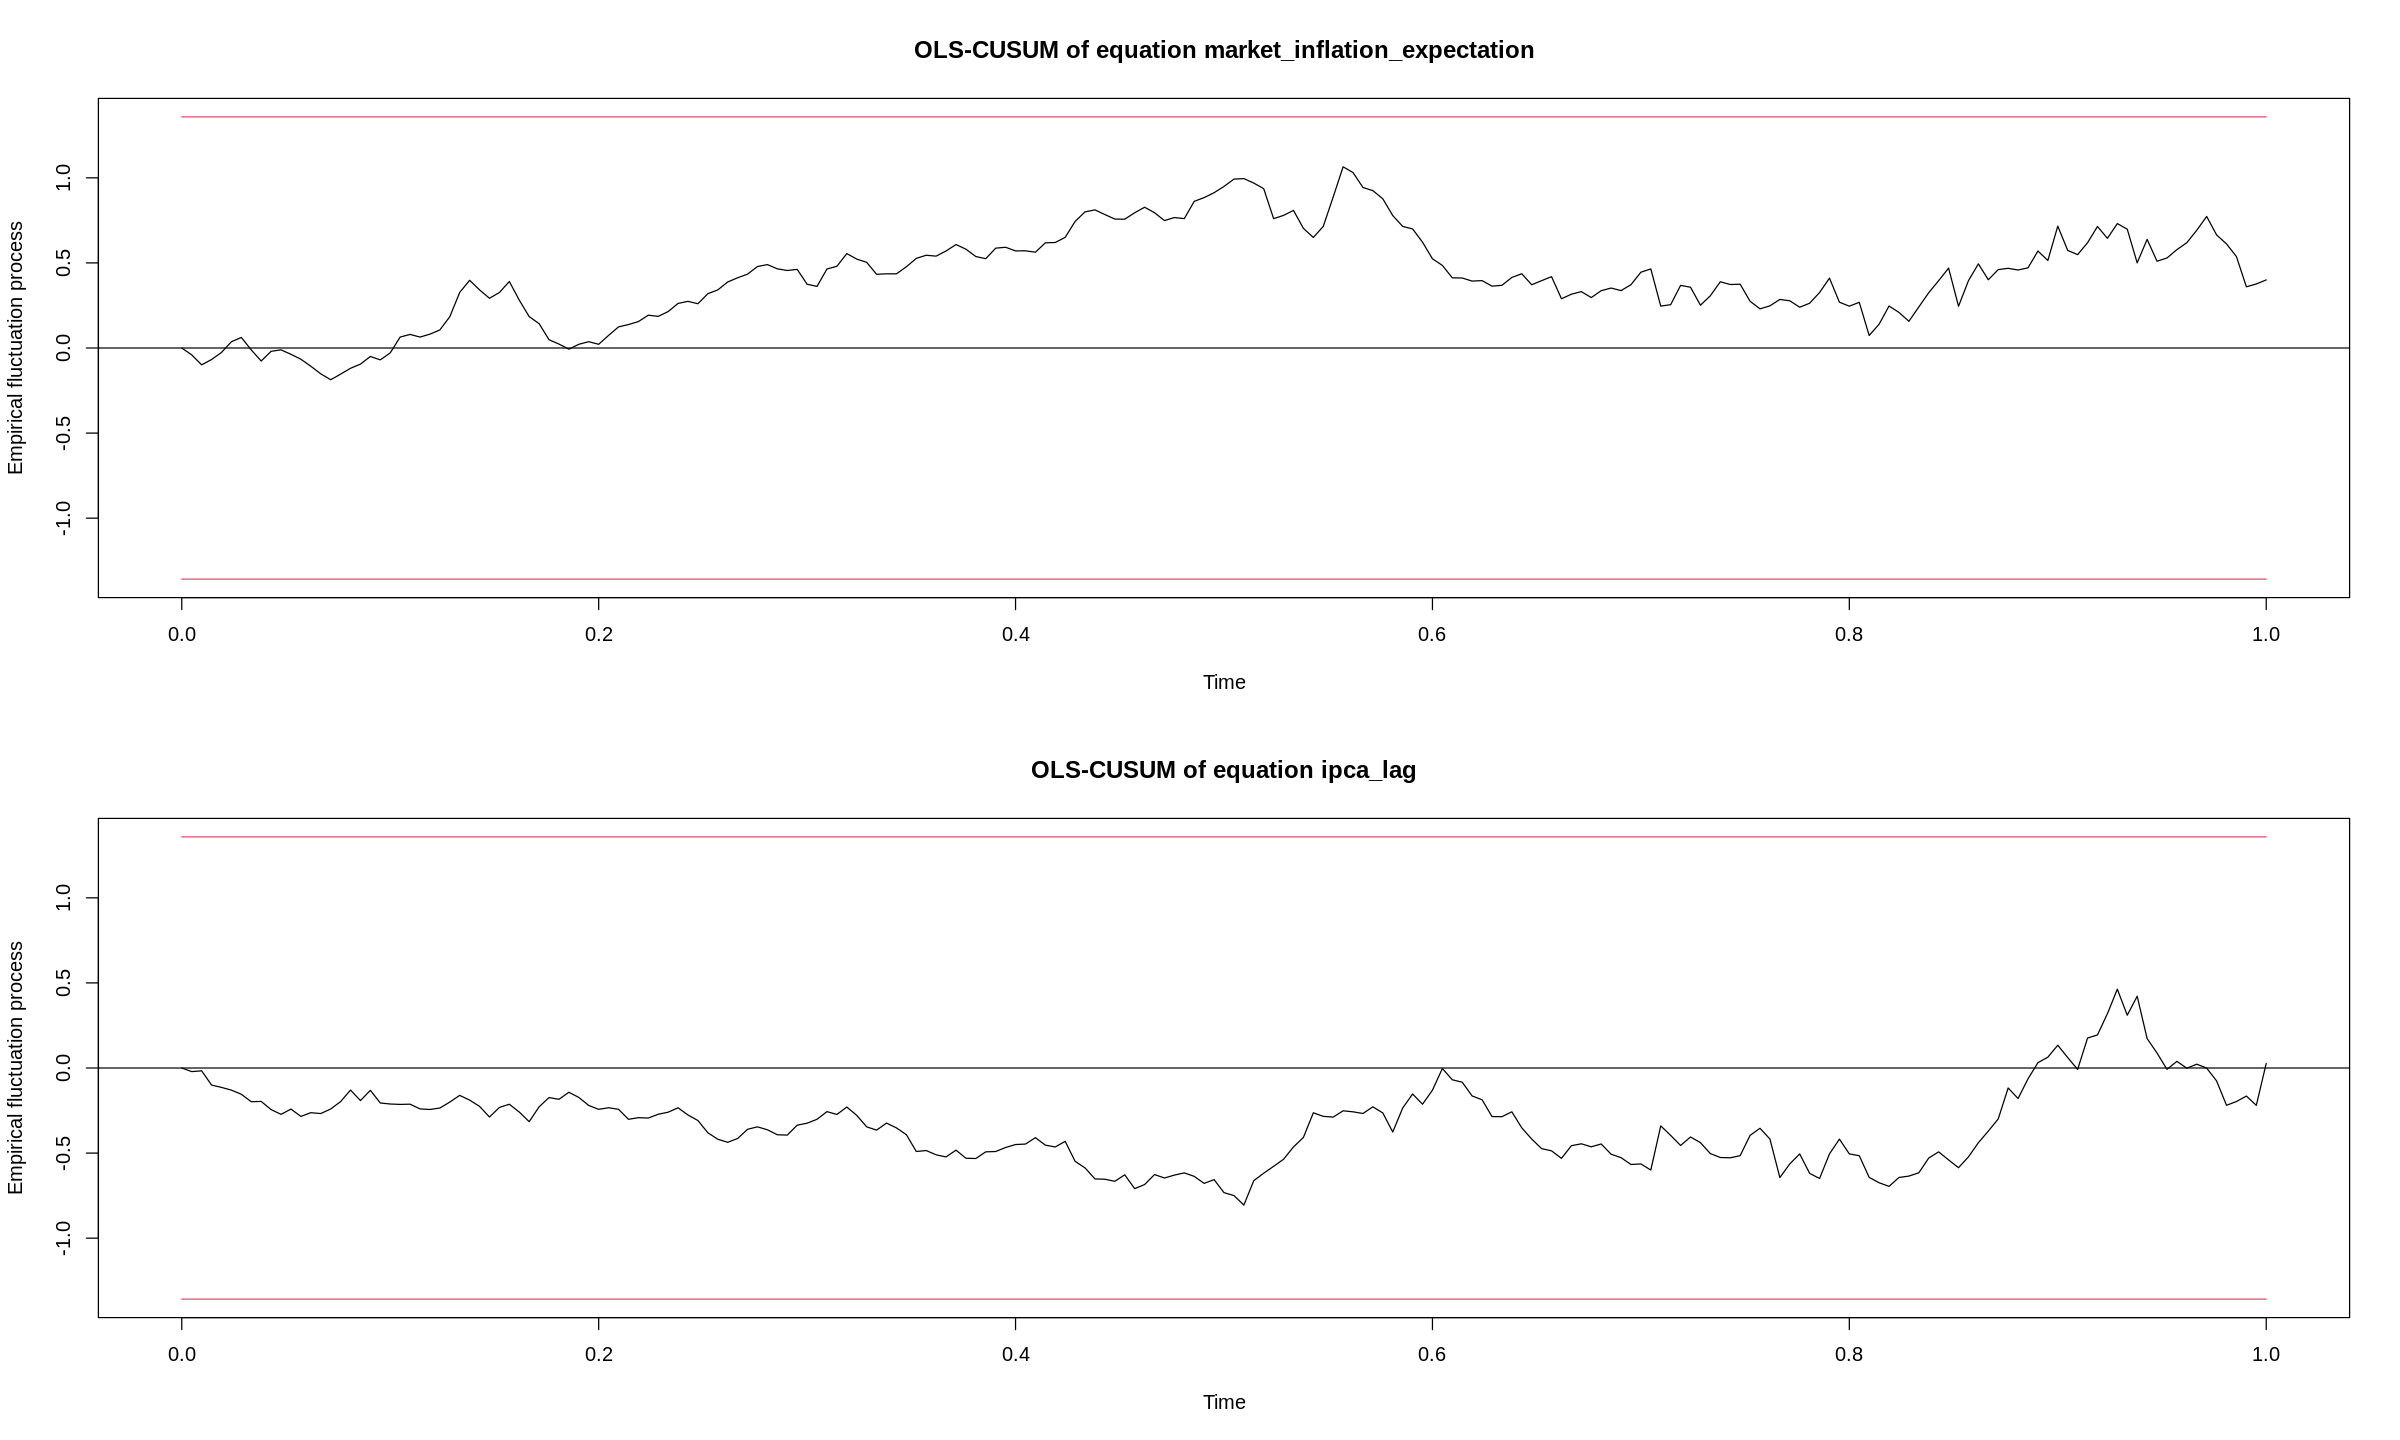

In [12]:
# Definir o tamanho da imagem de saída
options(repr.plot.width = 20, repr.plot.height = 12)

# Structural Breaks in Residuals
stability_test <- stability(var_model, type = "OLS-CUSUM")

plot(stability_test)

**Resultado**

- Como os valores estão entre as barras vermelhas, com exceção da variável relacionada ao resultado fiscal, pode-se afirmar que não há quebra estrutural nos resíduos

In [13]:
# Granger Causality
granger_consumer_expectation <- causality(var_model, cause = "ipca_lag")

print(granger_consumer_expectation)

$Granger

	Granger causality H0: ipca_lag do not Granger-cause
	market_inflation_expectation

data:  VAR object var_model
F-Test = 2.6107, df1 = 2, df2 = 412, p-value = 0.0747


$Instant

	H0: No instantaneous causality between: ipca_lag and
	market_inflation_expectation

data:  VAR object var_model
Chi-squared = 0.15707, df = 1, p-value = 0.6919




**Resultado**

- Como o p-valor é maior que um nível de significância de 5%, não se pode rejeitar a hipótese nula do teste de Granger e afirmar que IPCA causa, no sentido de Granger, variação na expectativa de inflação do mercado

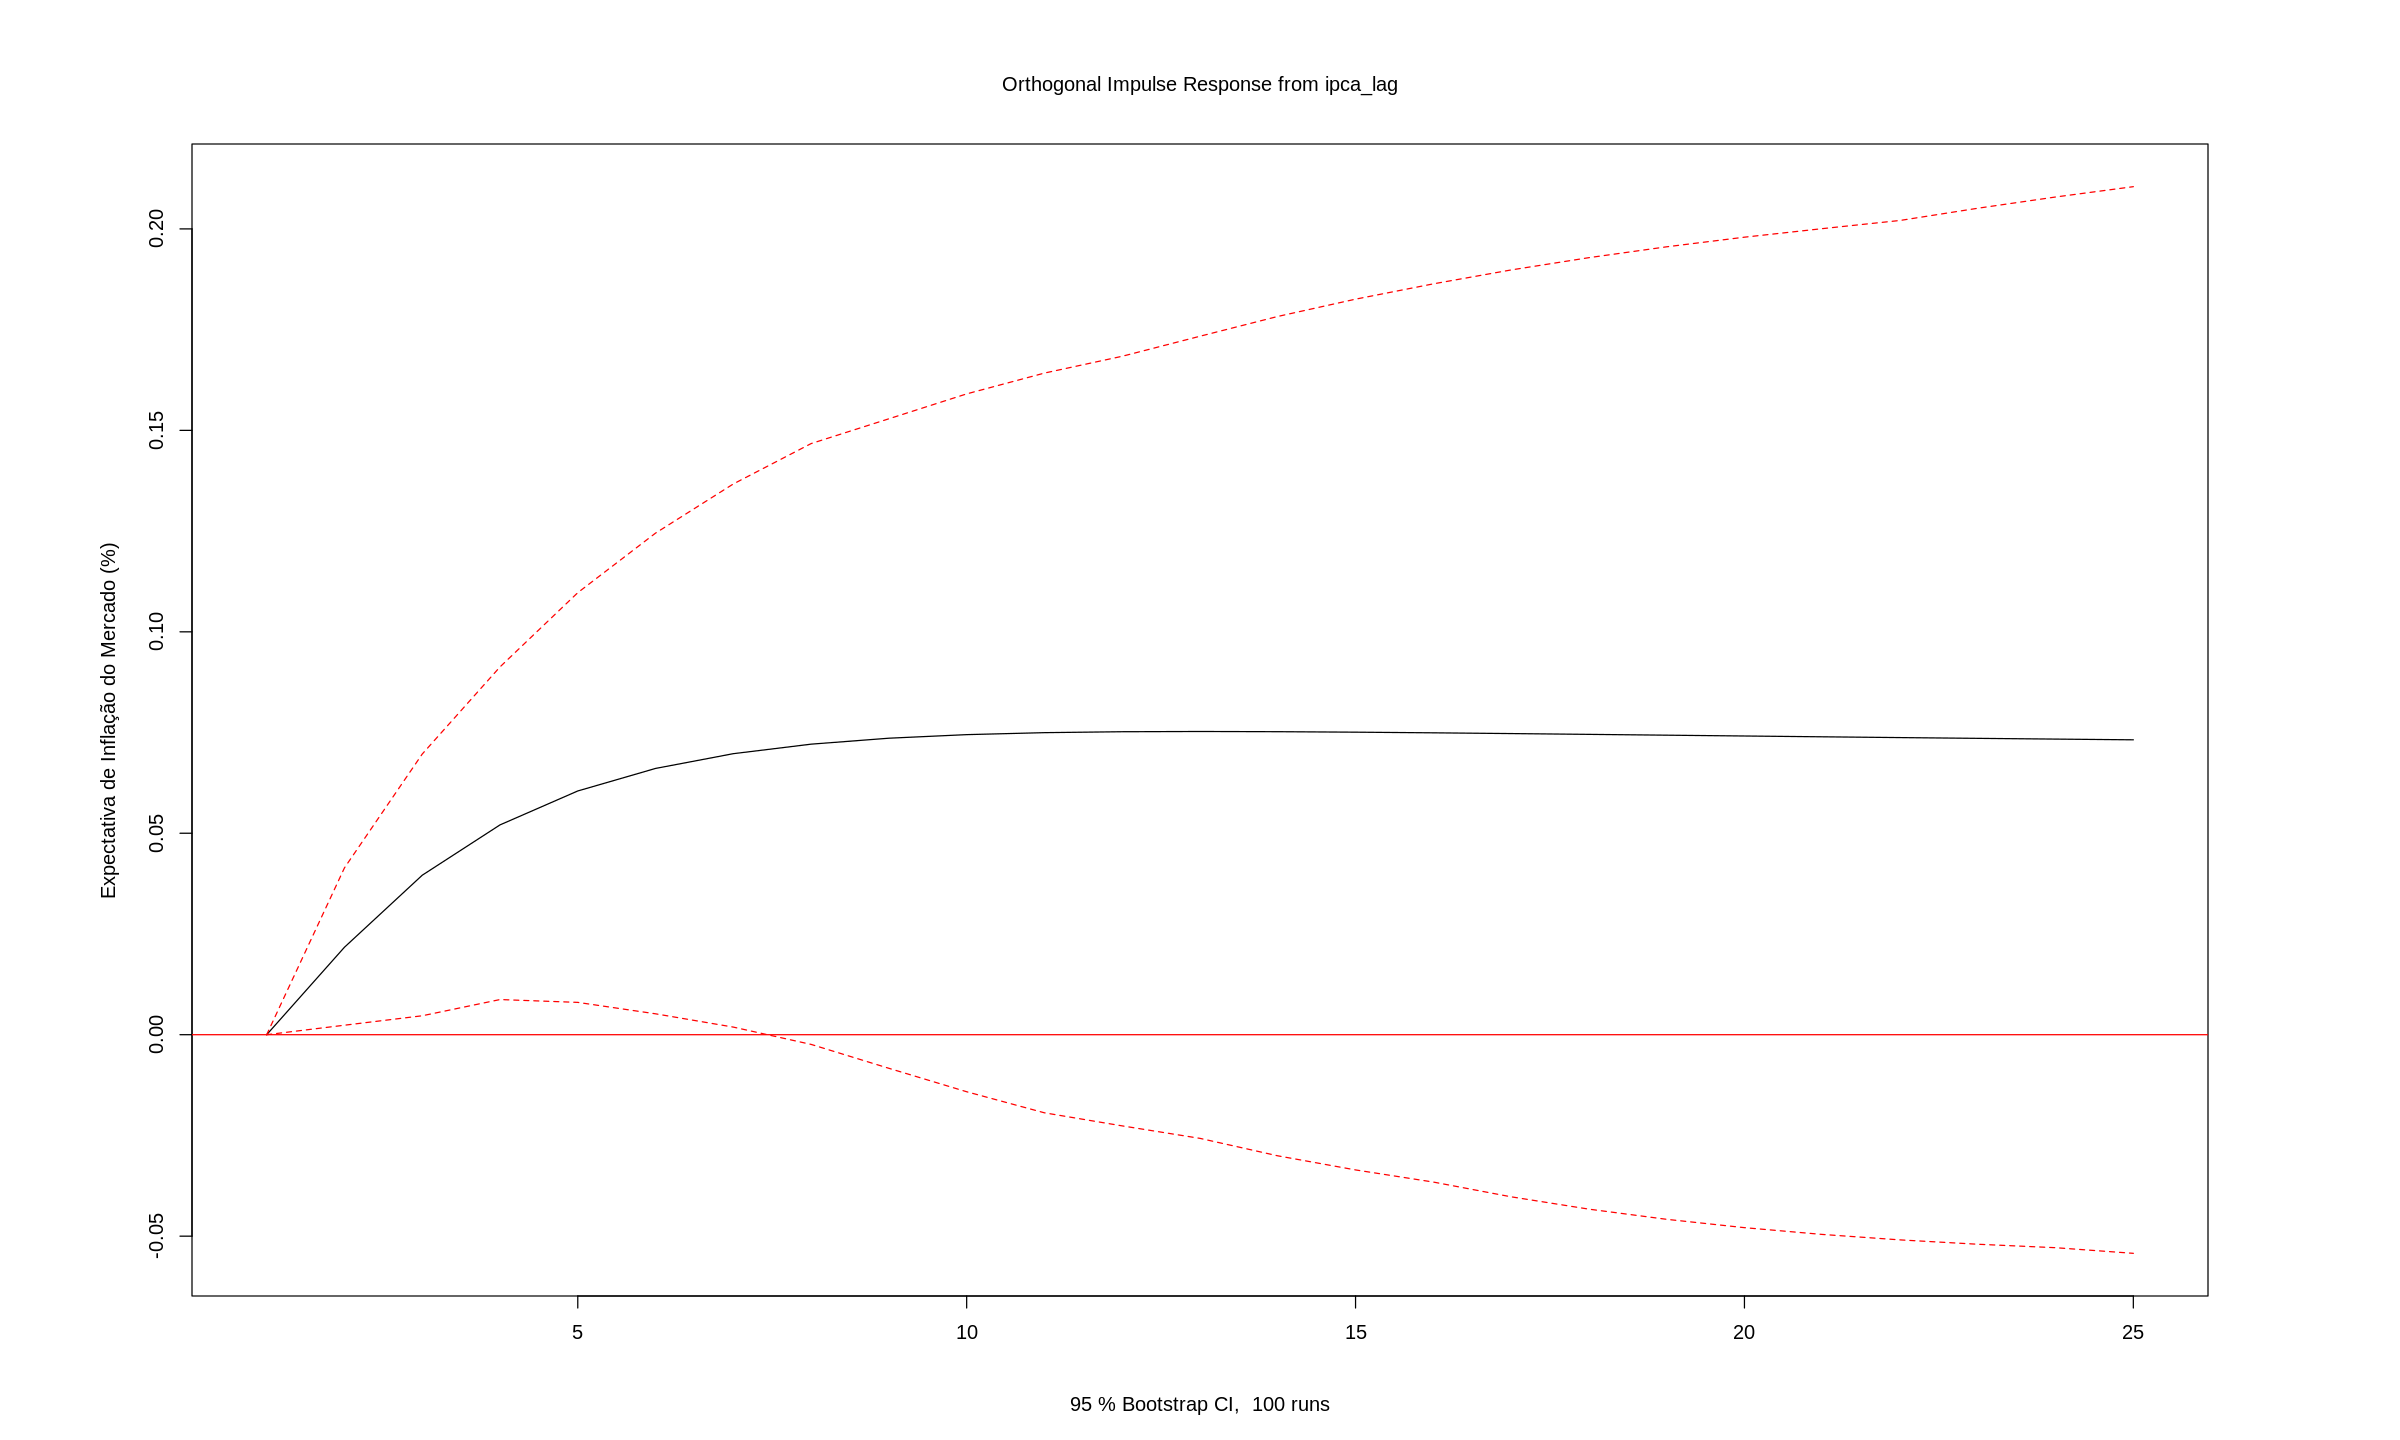

In [14]:
# Impulse Response Function
market_expectation_impulse = irf(var_model, impulse = "ipca_lag", response = "market_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)")

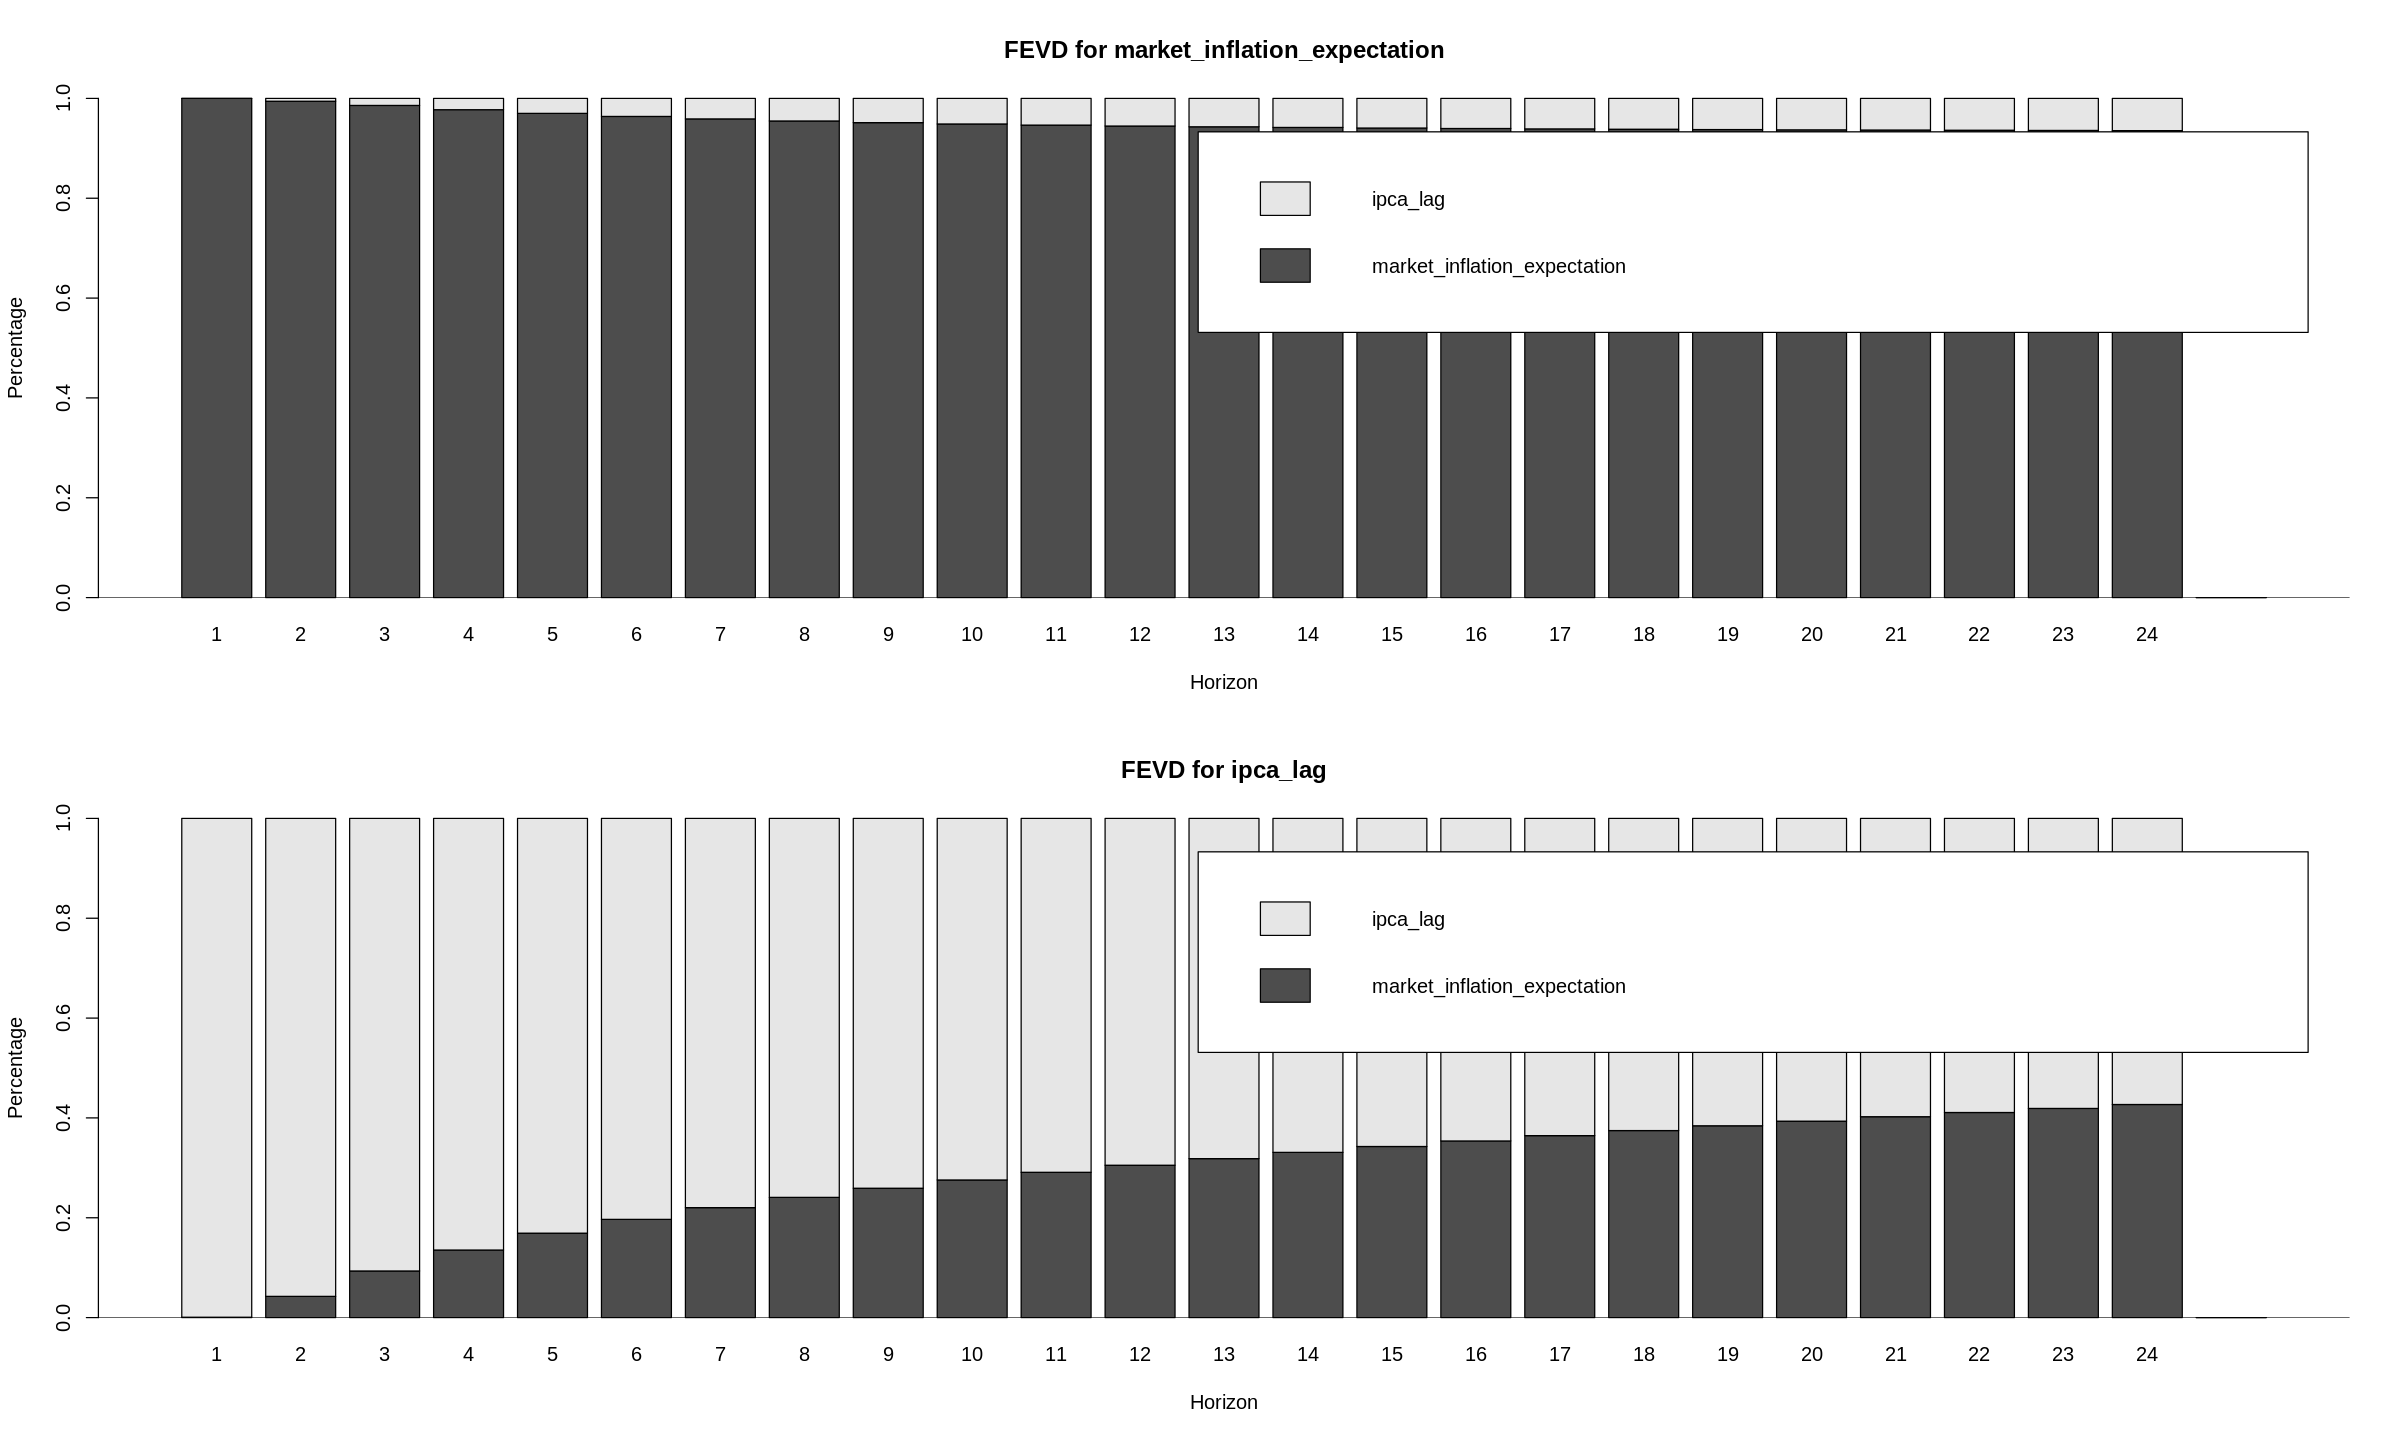

In [15]:
# Função de Variação de Valores Extremos
fevd_model <- fevd(var_model, n.ahead = 24)

plot(fevd_model)

**Resultado**

-

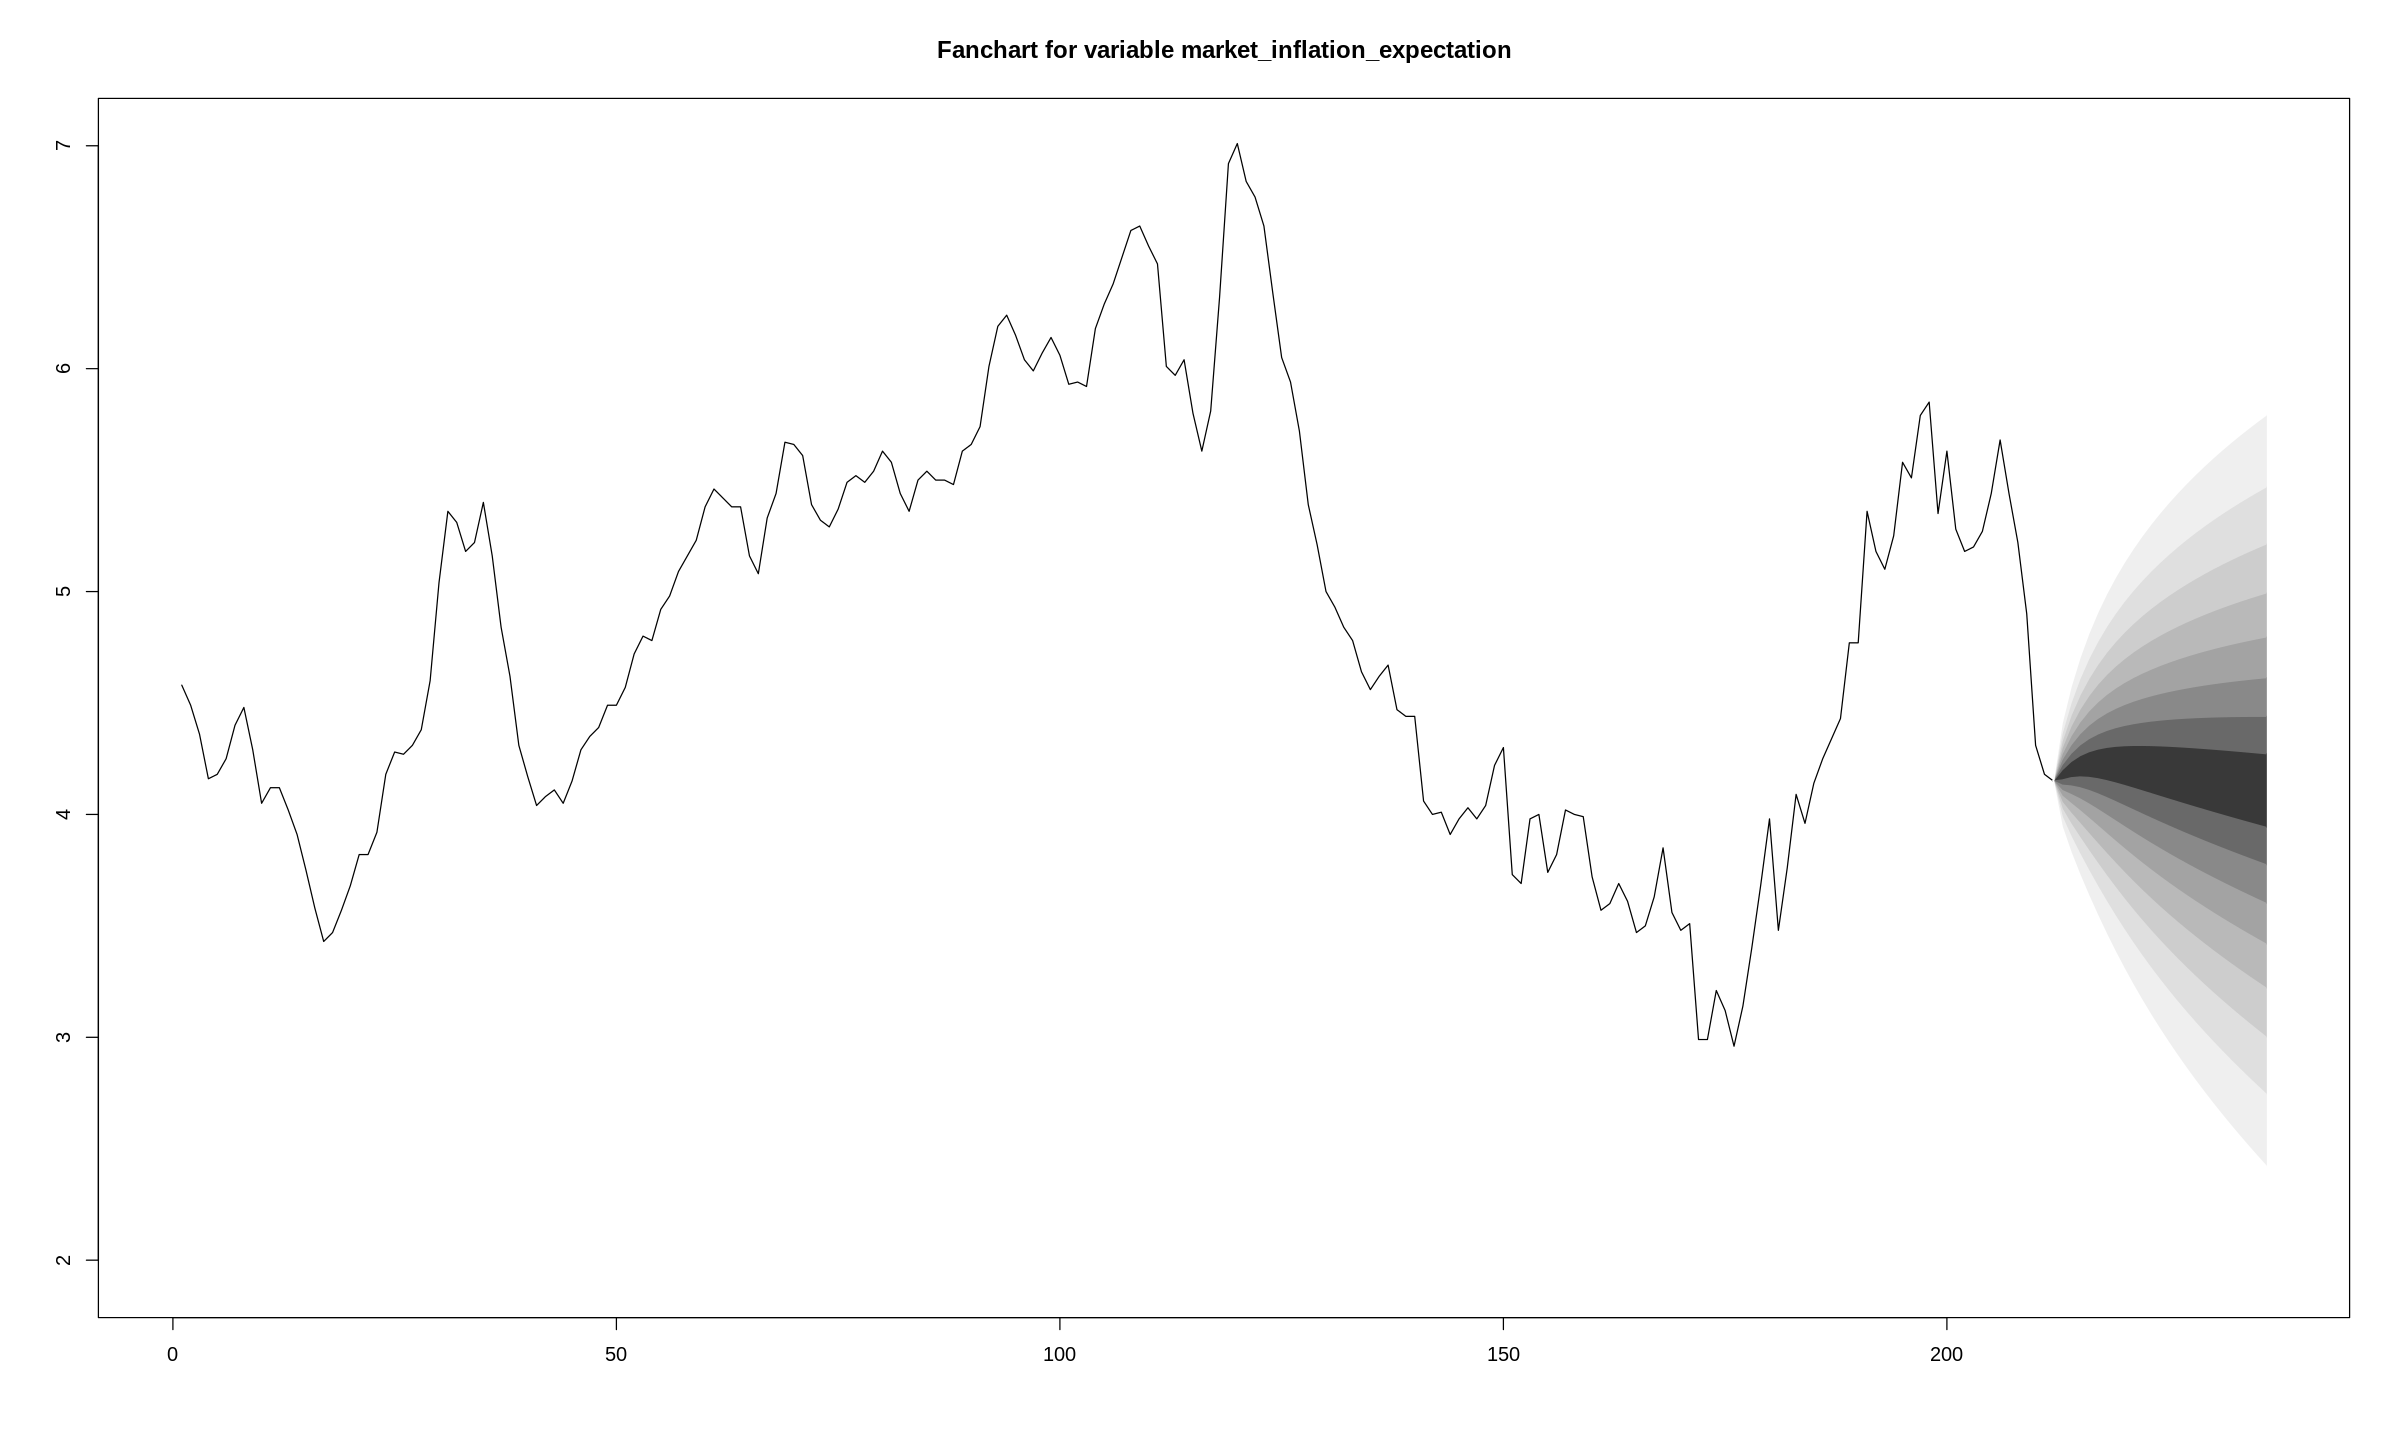

In [16]:
# Forecast using VAR
forecast_var <- predict(var_model, n.ahead = 24, ci = 0.95)

fanchart(forecast_var, names = "market_inflation_expectation")

### **Modelo VECM**

In [17]:
# Selecionar variáveis do modelo VECM
vecm_model_variables <- df_public_data[, c("market_inflation_expectation", "ipca")]

In [18]:
# Lag Selection (n-1)
vecm_lag <- VARselect(vecm_model_variables, lag.max = 12, type = "none")

print(vecm_lag$selection)

AIC(n)  HQ(n)  SC(n) FPE(n) 
    12      2      2     12 


In [19]:
# Johansen Test (Trace)
vecm_johansen_trace <- ca.jo(vecm_model_variables, type = "trace", ecdet = "none", K = 2)

summary(vecm_johansen_trace)


###################### 
# Johansen-Procedure # 
###################### 

Test type: trace statistic , with linear trend 

Eigenvalues (lambda):
[1] 0.06476493 0.02135010

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  4.53  6.50  8.18 11.65
r = 0  | 18.59 15.66 17.95 23.52

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                market_inflation_expectation.l2    ipca.l2
market_inflation_expectation.l2                        1.000000 1.00000000
ipca.l2                                               -0.569308 0.02038517

Weights W:
(This is the loading matrix)

                               market_inflation_expectation.l2     ipca.l2
market_inflation_expectation.d                     -0.02768549 -0.02348607
ipca.d                                              0.06353437 -0.04728455


**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 10%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é menor que critical value a um nível de significância de 10%, não se rejeita a hipótese nula, ou seja, existe no máximo 2 relações de cointegração no sistema

In [20]:
# Johansen Test (MaxEigen)
vecm_johansen_eigen <- ca.jo(vecm_model_variables, type = "eigen", ecdet = "none", K = 2)

summary(vecm_johansen_eigen)


###################### 
# Johansen-Procedure # 
###################### 

Test type: maximal eigenvalue statistic (lambda max) , with linear trend 

Eigenvalues (lambda):
[1] 0.06476493 0.02135010

Values of teststatistic and critical values of test:

          test 10pct  5pct  1pct
r <= 1 |  4.53  6.50  8.18 11.65
r = 0  | 14.06 12.91 14.90 19.19

Eigenvectors, normalised to first column:
(These are the cointegration relations)

                                market_inflation_expectation.l2    ipca.l2
market_inflation_expectation.l2                        1.000000 1.00000000
ipca.l2                                               -0.569308 0.02038517

Weights W:
(This is the loading matrix)

                               market_inflation_expectation.l2     ipca.l2
market_inflation_expectation.d                     -0.02768549 -0.02348607
ipca.d                                              0.06353437 -0.04728455


**Resultado**

- r = 0: Como teststatistic é maior que critical value a um nível de significância de 10%, rejeita-se a hipótese nula, ou seja, existe ao menos 1 relação de cointegração no sistema

- r <= 1: Como teststatistic é menor que critical value a um nível de significância de 10%, não se rejeita a hipótese nula, ou seja, existe no máximo 2 relações de cointegração no sistema

In [21]:
# Criar modelo VECM
vecm_model <- VECM(vecm_model_variables, 2, r = 1, estim = ("ML"))

summary(vecm_model)

#############
###Model VECM 
#############
Full sample size: 212 	End sample size: 209
Number of variables: 2 	Number of estimated slope parameters 12
AIC -1138.133 	BIC -1094.682 	SSR 36.19344
Cointegrating vector (estimated by ML):
   market_inflation_expectation       ipca
r1                            1 -0.6571999


                                      ECT                 Intercept         
Equation market_inflation_expectation -0.0143(0.0125)     0.0158(0.0186)    
Equation ipca                         0.0691(0.0263)**    -0.0746(0.0390).  
                                      market_inflation_expectation -1
Equation market_inflation_expectation 0.2886(0.0742)***              
Equation ipca                         0.0796(0.1560)                 
                                      ipca -1            
Equation market_inflation_expectation -0.0254(0.0354)    
Equation ipca                         0.5086(0.0744)***  
                                      market_inflation_expectat

In [22]:
# VECM specification to VAR specification
vecm_model_formatted <- vec2var(vecm_johansen_trace, r = 1)

In [23]:
# Serial Correlation
vecm_serial_test <- serial.test(vecm_model_formatted, lags.pt = 12, type = "PT.asymptotic")

print(vecm_serial_test)


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 133.5, df = 42, p-value = 1.842e-11



$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 133.5, df = 42, p-value = 1.842e-11



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que as variáveis não possuem correlação serial

In [24]:
# Heteroscedasticity
vecm_arch_test <- arch.test(vecm_model_formatted, lags.multi = 12, multivariate.only = TRUE)

print(vecm_arch_test)


	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 217.93, df = 108, p-value = 2.018e-09



$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 217.93, df = 108, p-value = 2.018e-09



**Resultado**

- Como o p-value é menor que um nível de significância de 5%, não se pode afirmar que o modelo não possui heteroscedasticidade

In [25]:
# Normal Distribution of Residuals
vecm_normal_test <- normality.test(vecm_model_formatted, multivariate.only = TRUE)

print(vecm_normal_test)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 70.574, df = 4, p-value = 1.721e-14


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 15.309, df = 2, p-value = 0.000474


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 55.265, df = 2, p-value = 9.985e-13




$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 70.574, df = 4, p-value = 1.721e-14


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 15.309, df = 2, p-value = 0.000474


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object vecm_model_formatted
Chi-squared = 55.265, df = 2, p-value = 9.985e-13




**Resultado**

- Como o p-value é menor que um nível de significância de 5% no JB-test, não se pode afirmar que os resíduos são distribuídos de forma gaussiana

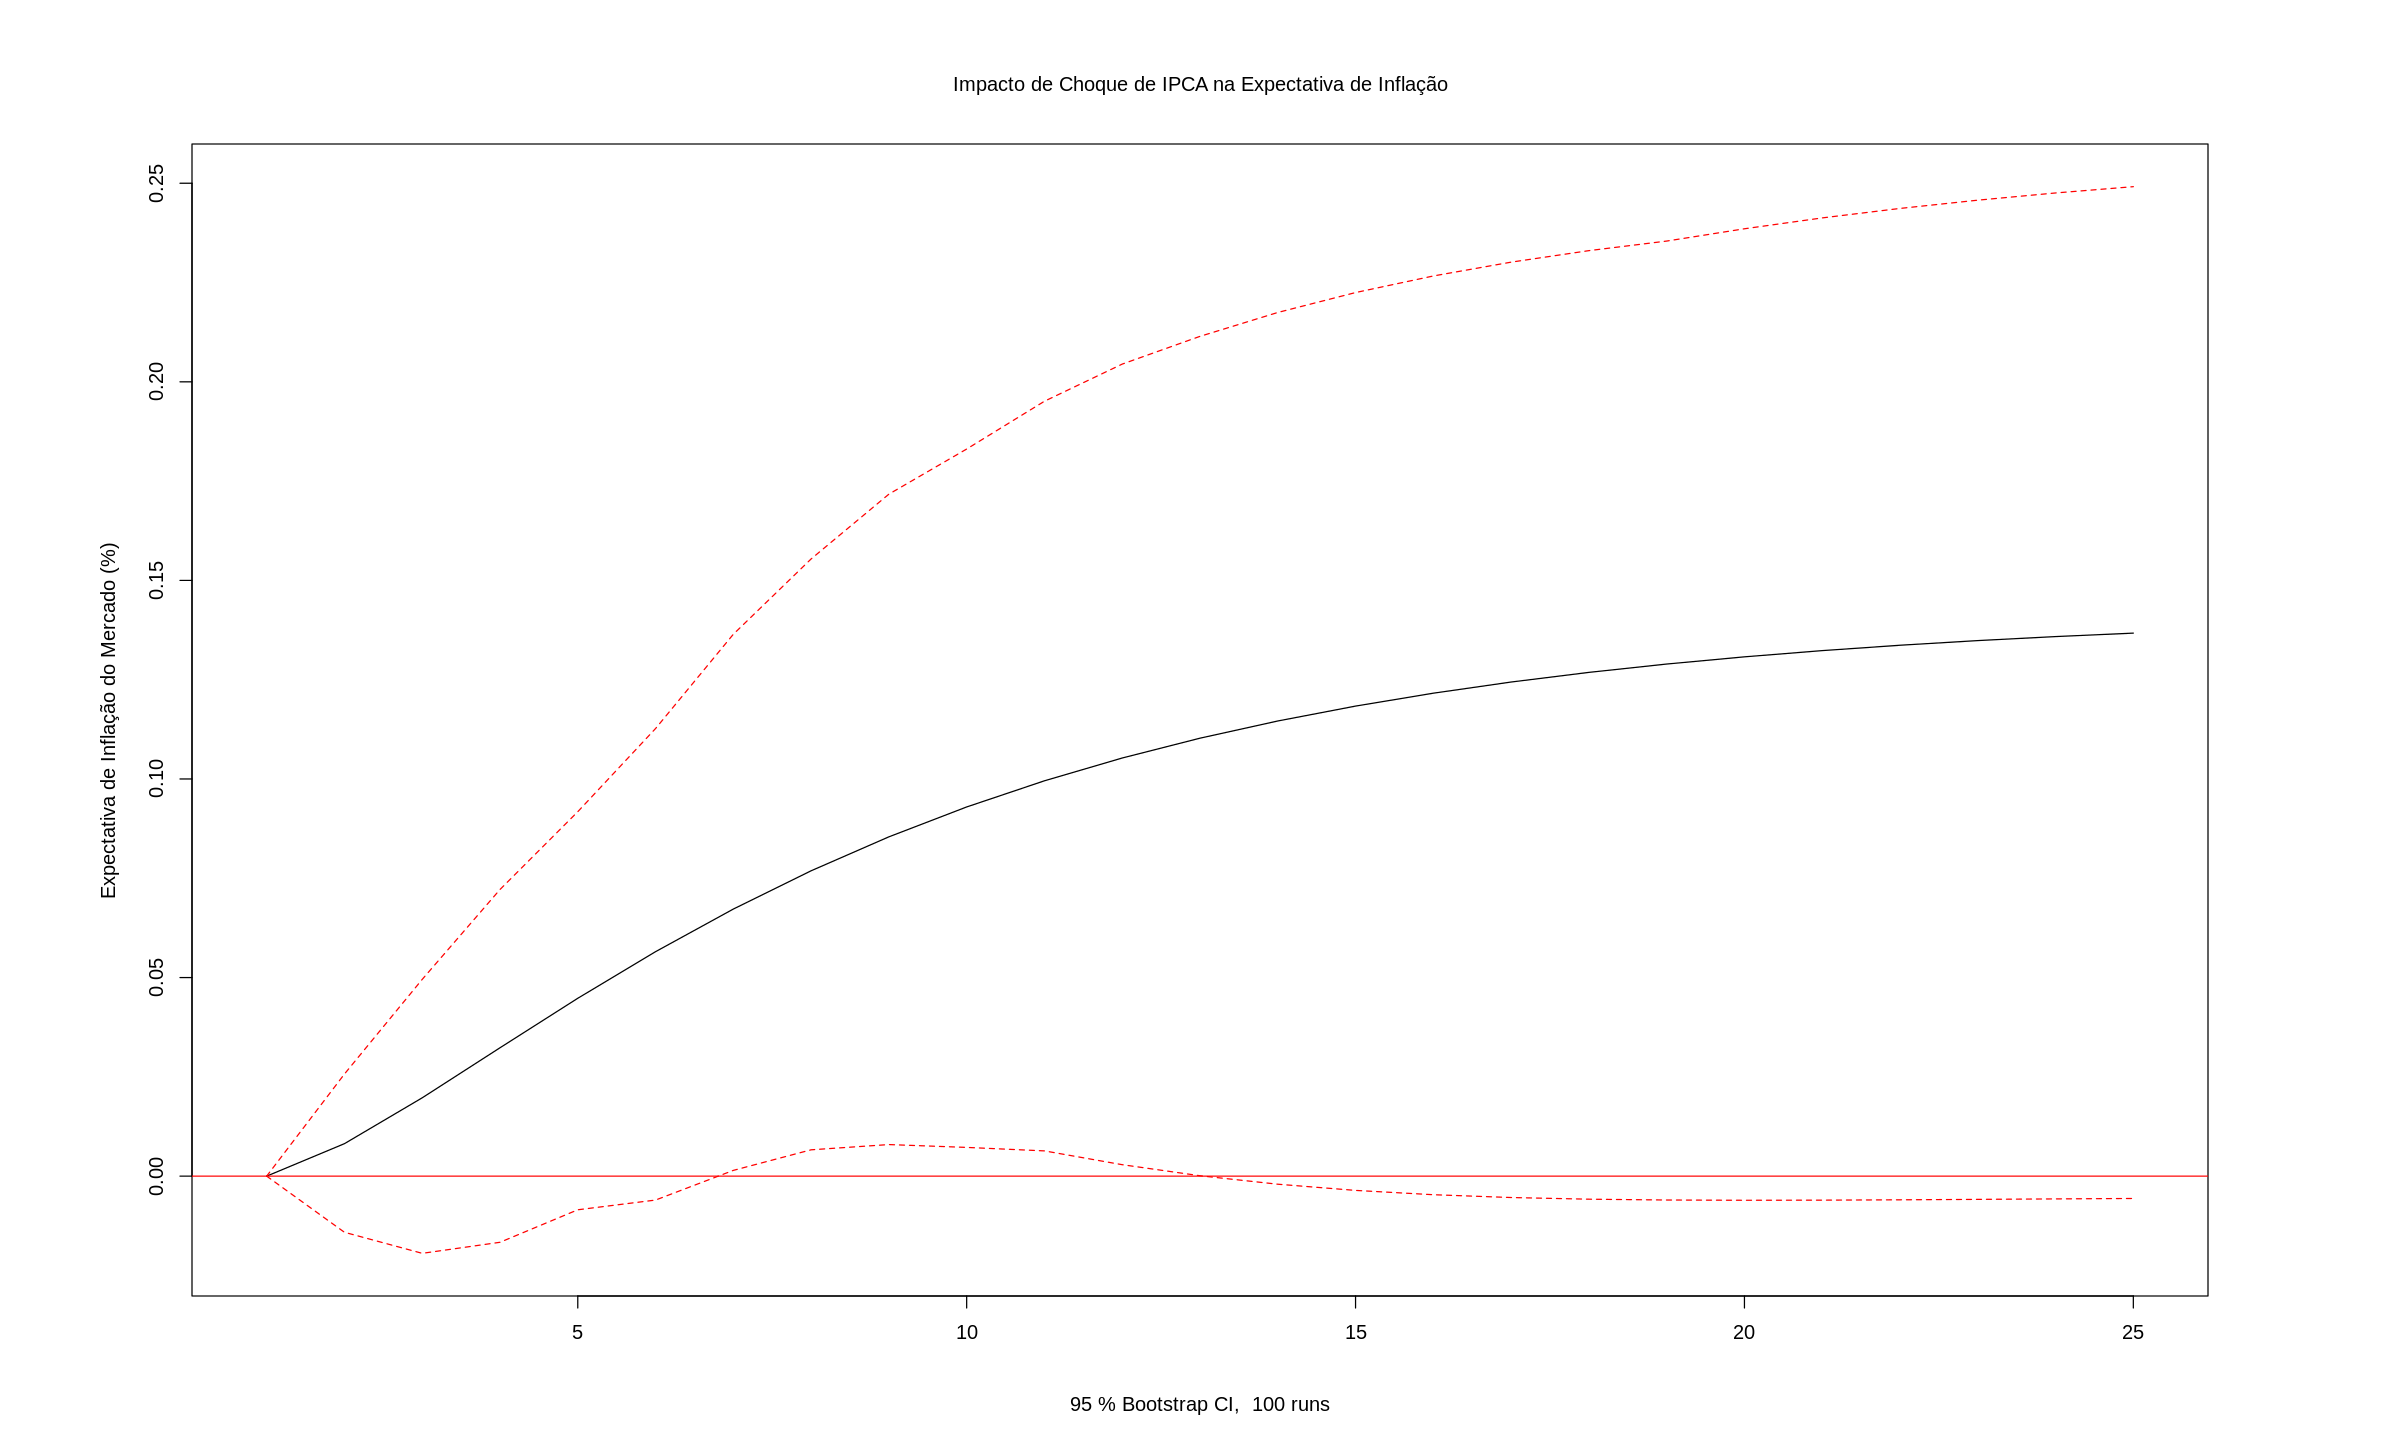

In [26]:
# Impulse Response Function
vecm_ipca_market_expectation_impulse = irf(vecm_model_formatted, impulse = "ipca", response = "market_inflation_expectation", n.ahead = 24, boot = TRUE)

plot(vecm_ipca_market_expectation_impulse, ylab = "Expectativa de Inflação do Mercado (%)", main = "Impacto de Choque de IPCA na Expectativa de Inflação")

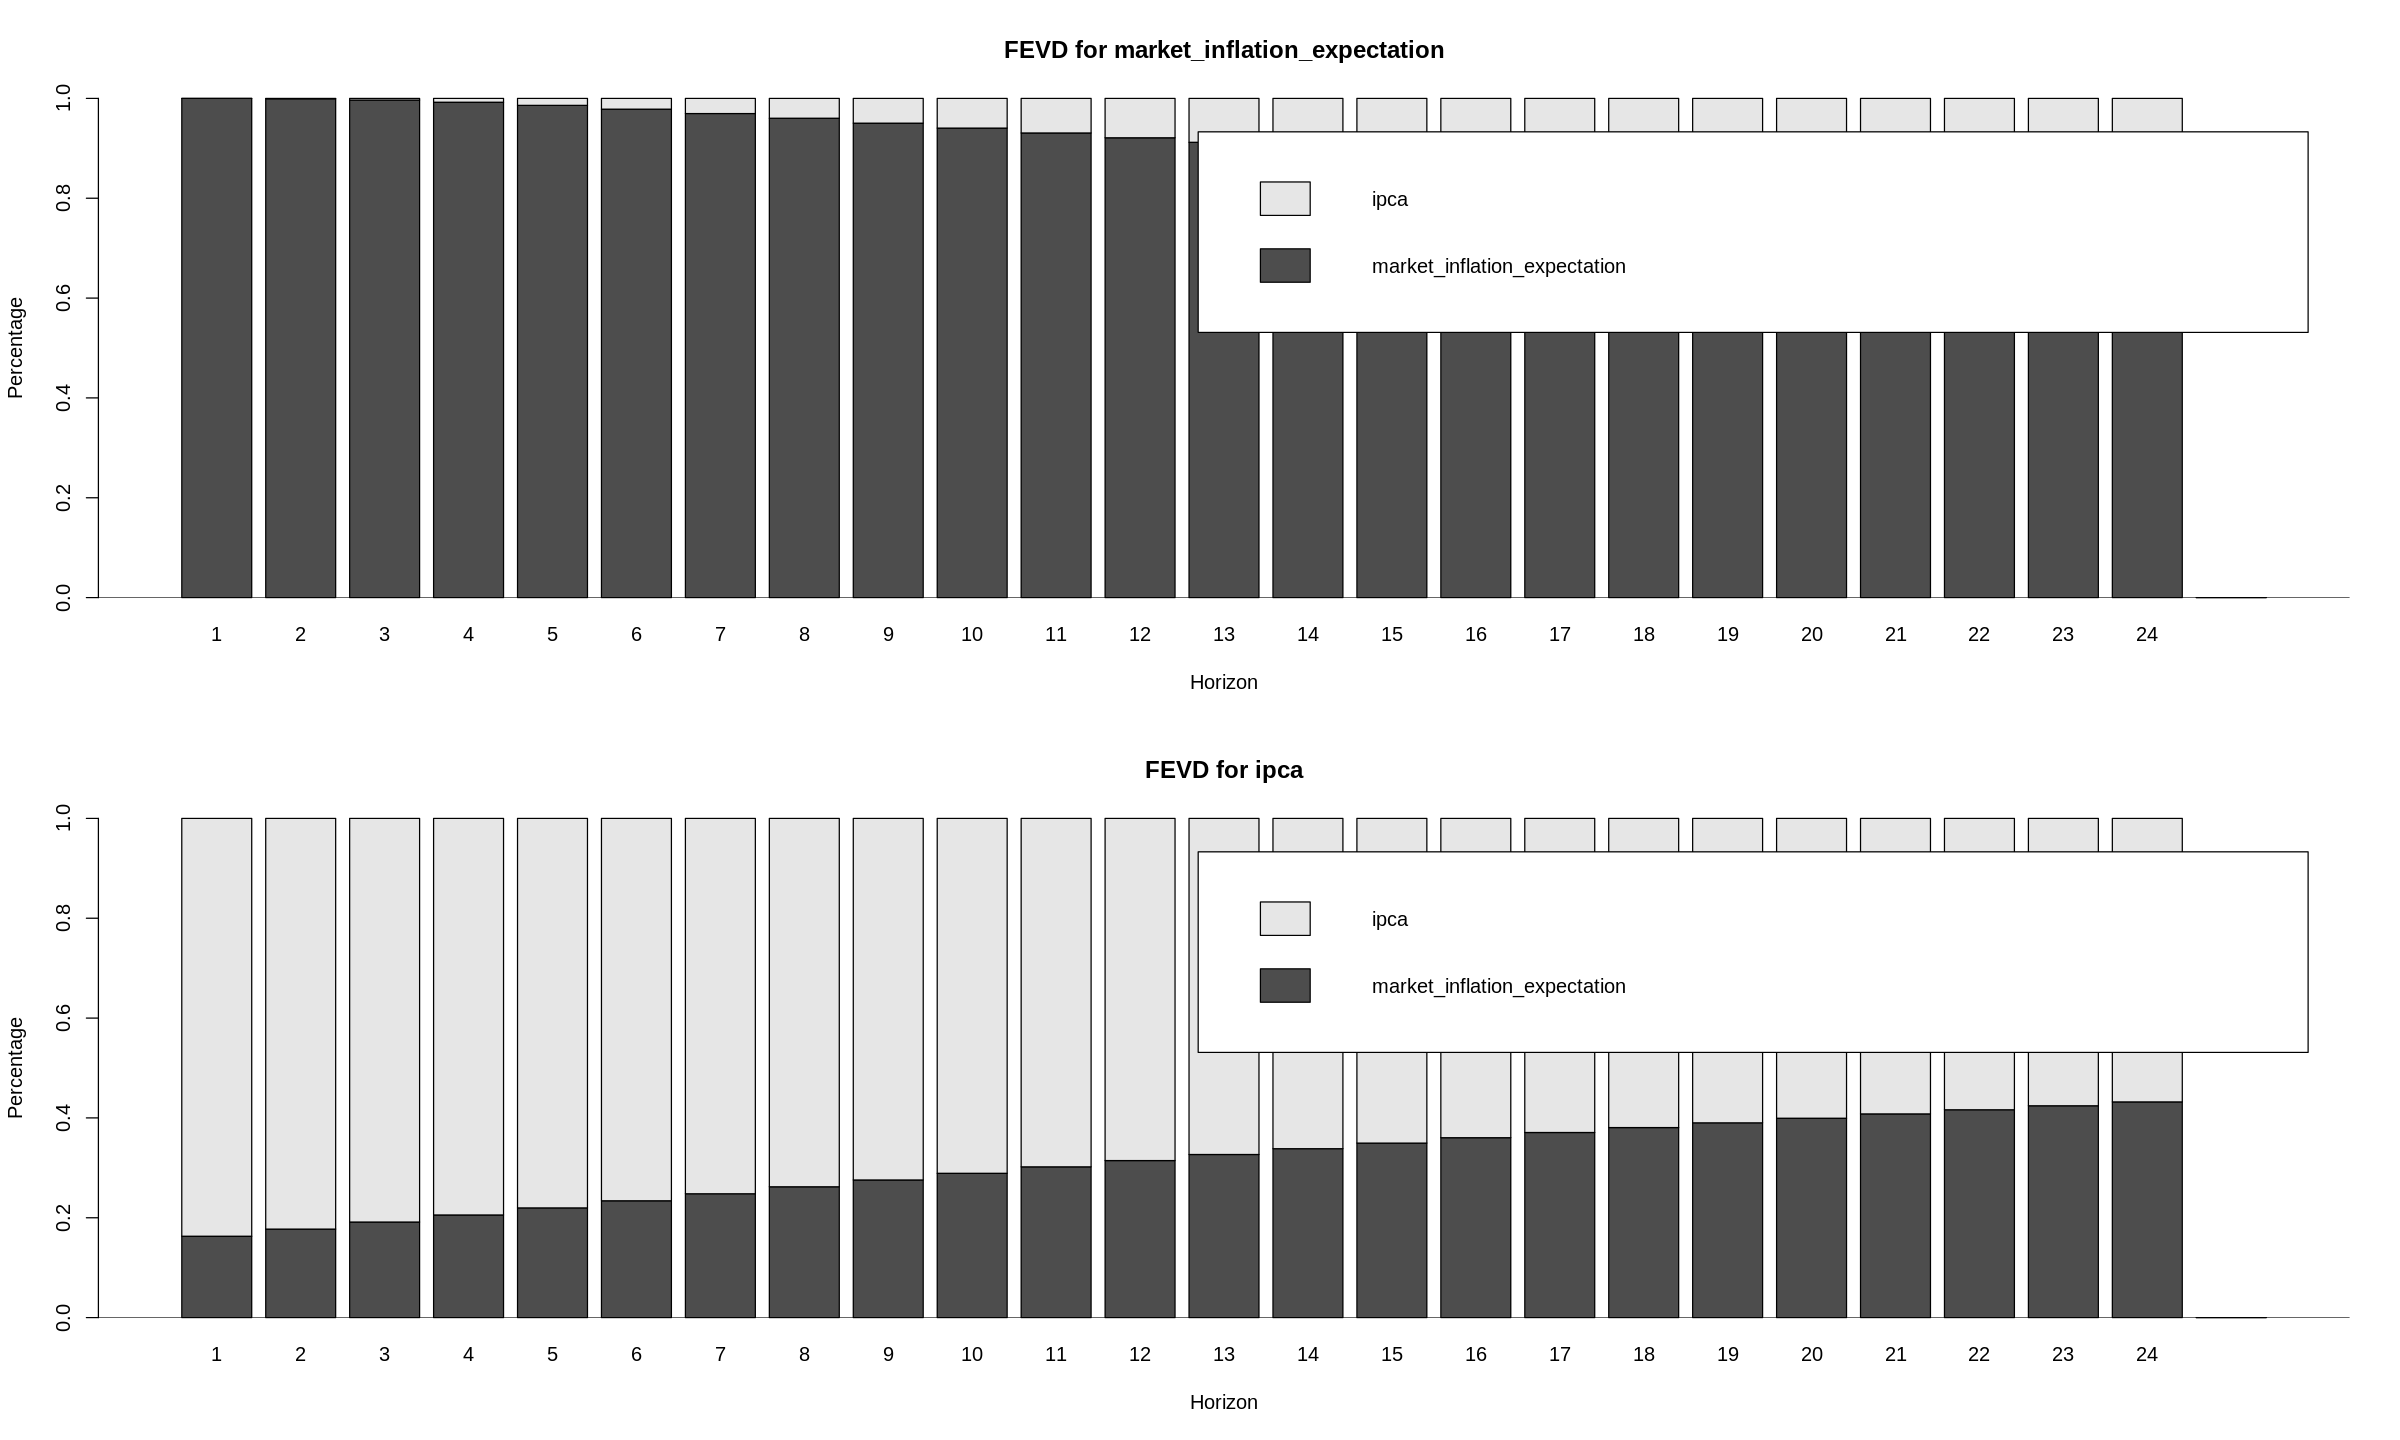

In [27]:
# Variance Decomposition
vecm_fevd <- fevd(vecm_model_formatted, n.ahead = 24)

plot(vecm_fevd)

**Resultado**

-

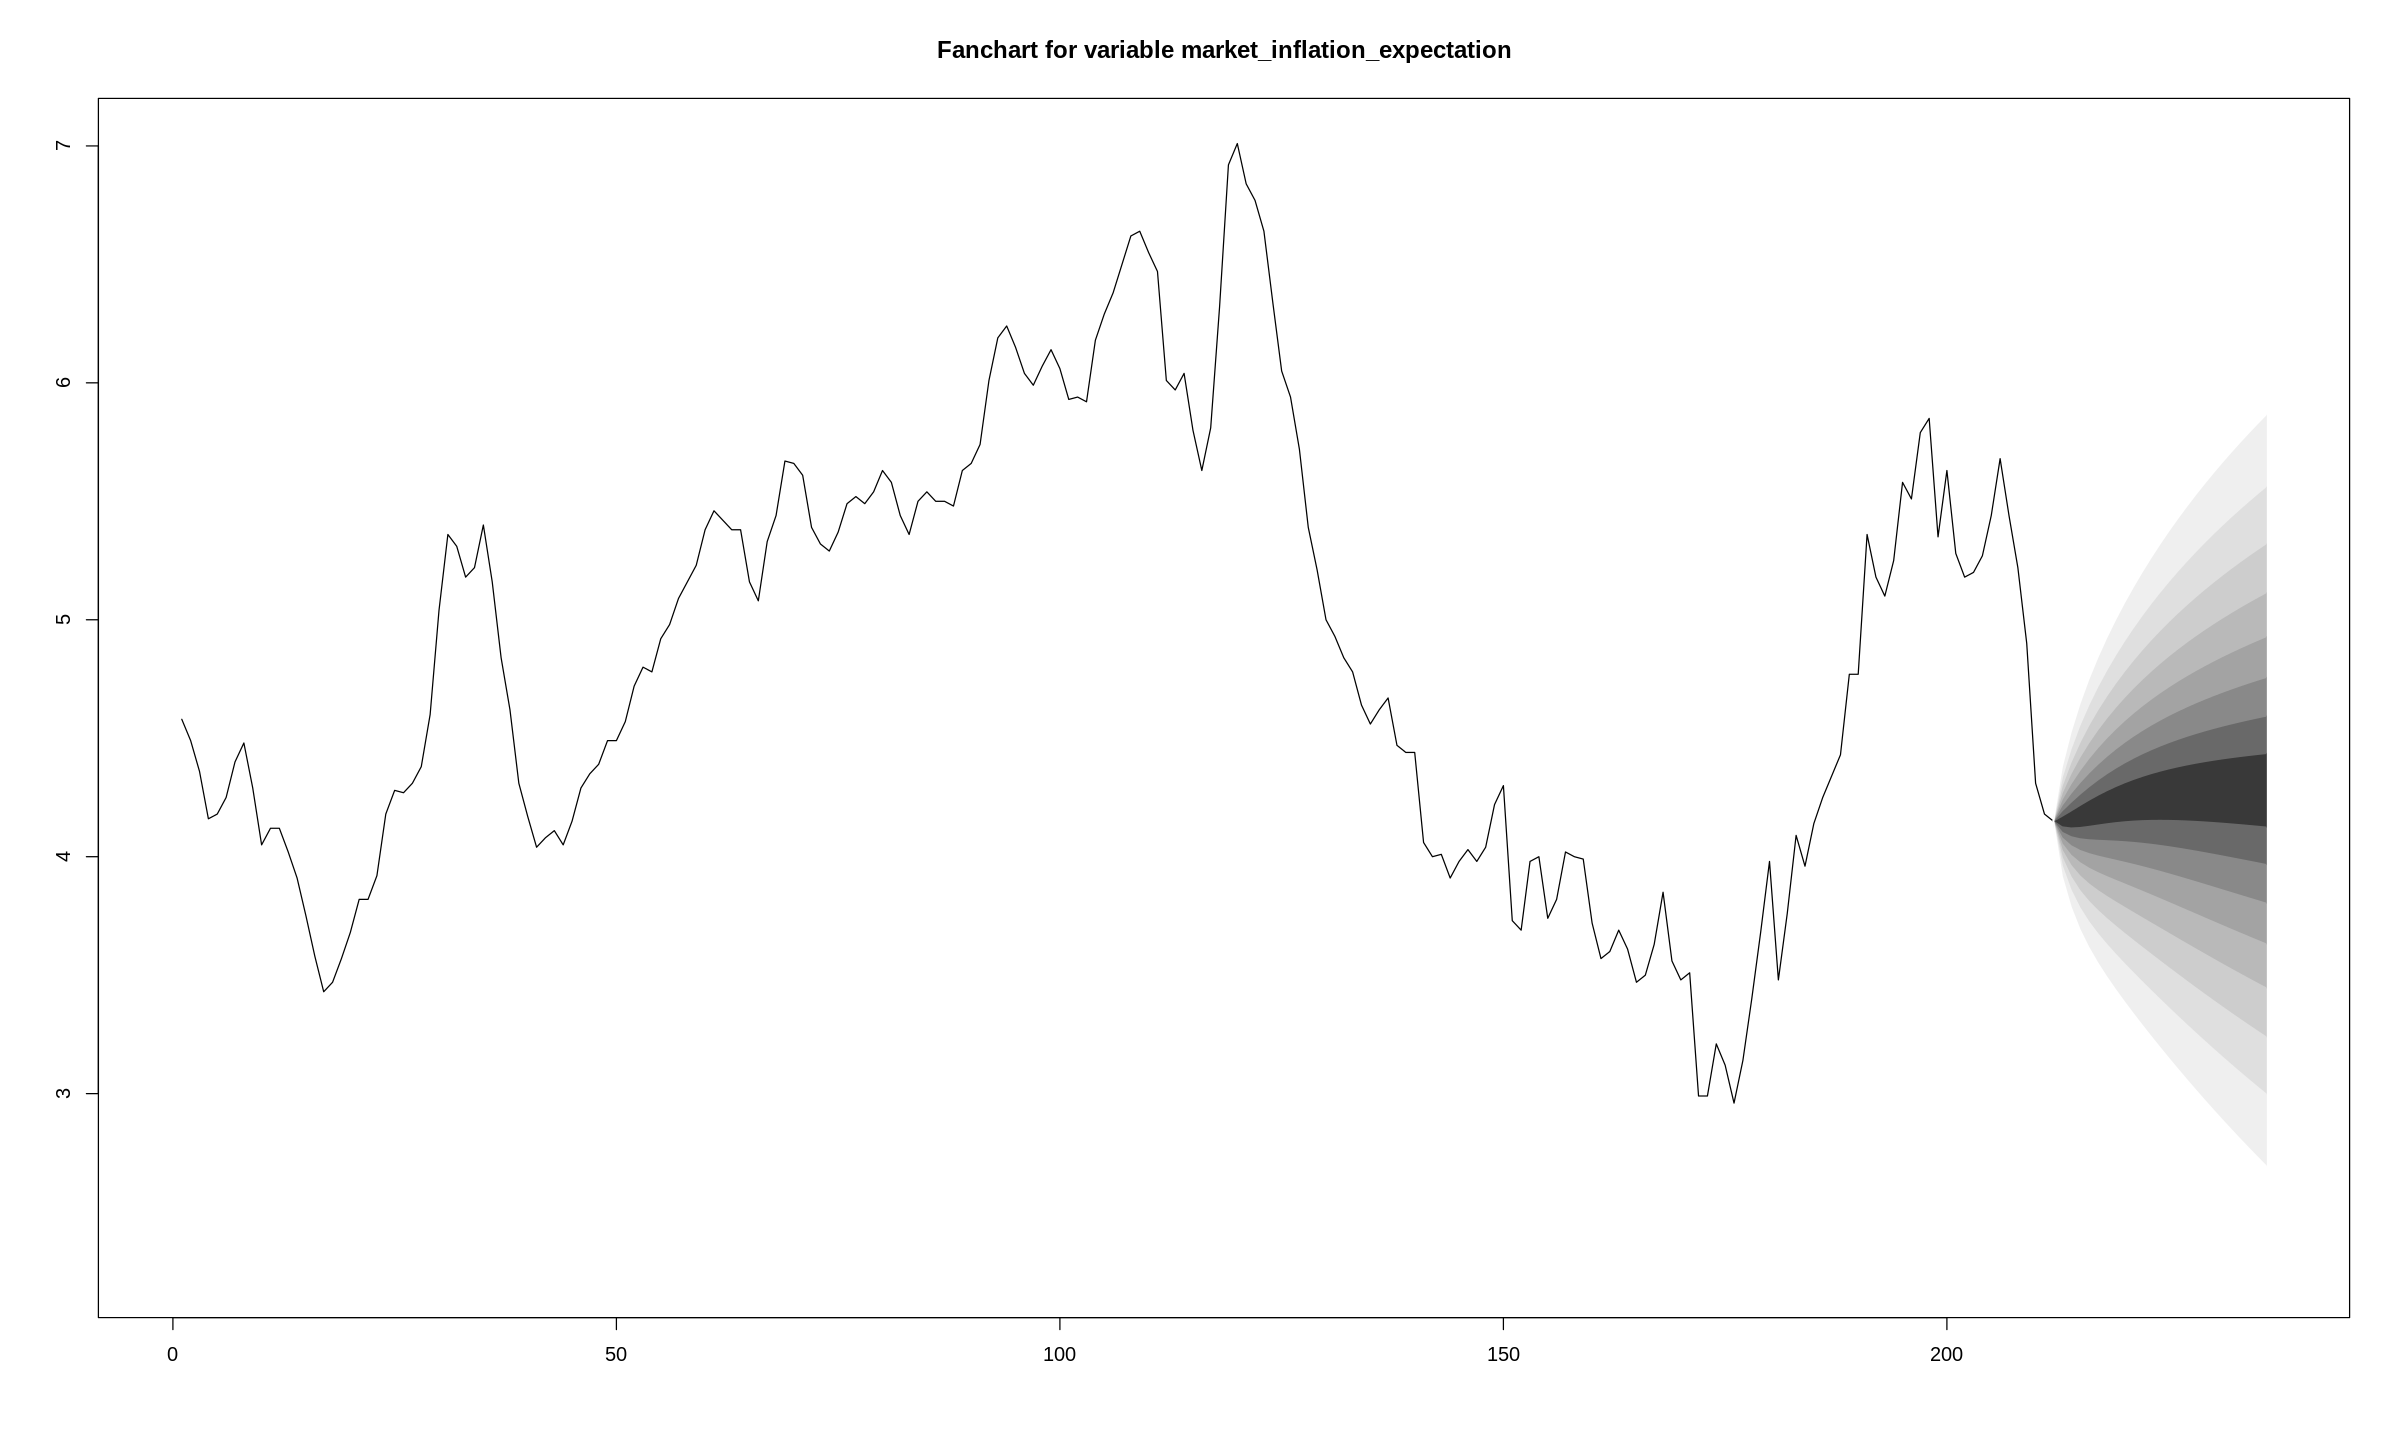

In [28]:
# Forecast using VECM
forecast_vecm <- predict(vecm_model_formatted, n.ahead = 24, ci = 0.95)

fanchart(forecast_vecm, names = "market_inflation_expectation")